In [14]:
%%javascript
Jupyter.notebook.get_cells().map(function(cell) {
  if (cell.cell_type === 'code') {
    cell.code_mirror.setOption('indentUnit', 2);
    cell.code_mirror.setOption('tabSize', 2);
  }
});

<IPython.core.display.Javascript object>

# 1. Import Required Packages

In [15]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import functional as T

from torchmetrics import Accuracy

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm

In [16]:
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu")
device

device(type='mps')

## 2. Dataset Preparation and Visualization

In [17]:
default_test_dataset = datasets.CIFAR10(
  root="data",
  download=True,
  train=False,
  transform=None
)

Files already downloaded and verified


In [64]:
mean = torch.tensor((0.4914, 0.4822, 0.4465))
std = torch.tensor((0.2023, 0.1994, 0.2010))

def fix_scale_transform(s, random_crop=True):
  return transforms.Compose([
    transforms.Resize(s),
    transforms.RandomCrop(32) if random_crop else transforms.Lambda(lambda x: x),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(
      brightness=0.2,
      contrast=0.2,
      saturation=0.2,
      hue=0.2
    ),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
  ])

def multi_scale_transform(s_min, s_max):
  area = 32**2
  min_area = s_min**2
  max_area = s_max**2
  
  return transforms.Compose([
    transforms.RandomResizedCrop(
      size=32,
      scale=(area / max_area, area / min_area),
      ratio=(1.0, 1.0)
    ),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(
      brightness=0.2,
      contrast=0.2,
      saturation=0.2,
      hue=0.2
    ),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
  ])

In [65]:
def denormalize(img: torch.Tensor):
  return torch.clamp(img * std[:, None, None] + mean[:, None, None], min=0)

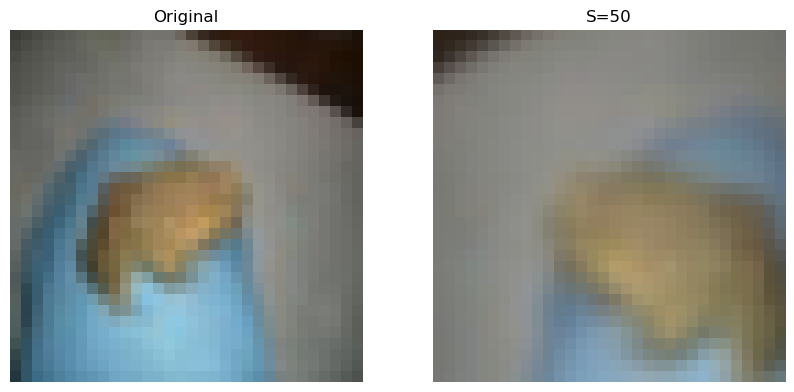

In [67]:
s = 50

img, label = default_test_dataset[np.random.choice(len(default_test_dataset))]
img_fst_50 = fix_scale_transform(s)(img)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(img)
plt.axis(False)

plt.subplot(1, 2, 2)
plt.title("S=50")
plt.imshow(denormalize(img_fst_50).permute(1, 2, 0))
plt.axis(False)

plt.show()

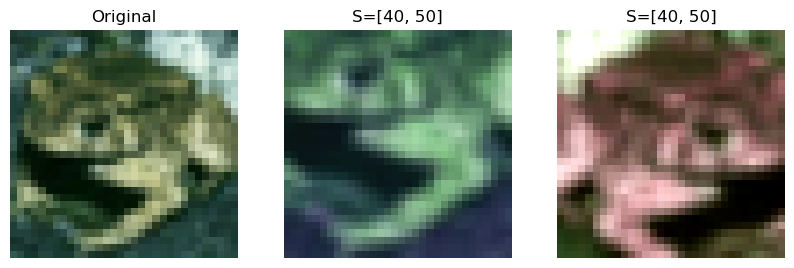

In [68]:
s_min, s_max = 40, 50

mst_40_50 = multi_scale_transform(s_min, s_max)

img, label = default_test_dataset[np.random.choice(len(default_test_dataset))]
img_mst_40_50_1 = mst_40_50(img)
img_mst_40_50_2 = mst_40_50(img)

plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.title("Original")
plt.imshow(img)
plt.axis(False)

plt.subplot(1, 3, 2)
plt.title("S=[40, 50]")
plt.imshow(denormalize(img_mst_40_50_1).permute(1, 2, 0))
plt.axis(False)

plt.subplot(1, 3, 3)
plt.title("S=[40, 50]")
plt.imshow(denormalize(img_mst_40_50_2).permute(1, 2, 0))
plt.axis(False)

plt.show()

In [69]:
class PairedFlipDataset(Dataset):
  """
  Wraps a base dataset that already includes transforms, and returns
  both the original image and its horizontally flipped version, along with the label.

  Assumes:
      - The base dataset returns (transformed_image, label) pairs.
      - The image is already preprocessed (e.g., resized, normalized).

  Returns:
      (original_image, flipped_image, label)
  """
  
  def __init__(self, base_dataset):
    self.base_dataset = base_dataset
    
  def __len__(self):
    return len(self.base_dataset)
  
  def __getitem__(self, idx):
    img, label = self.base_dataset[idx]
    
    img_flipped = T.hflip(img)
    
    return img, img_flipped, label

class MultiTransformDataset(Dataset):
  """
  Applies multiple transforms to the same input image from the base dataset,
  and returns all transformed versions along with the label.

  Assumes:
      - The base dataset returns (PIL image, label) pairs, with no transform applied.
      - A list of transform functions (e.g., torchvision.transforms.Compose) is provided.

  Args:
      base_dataset: A dataset yielding untransformed (PIL image, label) pairs.
      *trans: One or more transform functions to apply to the input image.

  Returns:
      (*transformed_images, label)
  """
  
  def __init__(self, base_dataset, *trans):
    self.base_dataset = base_dataset
    self.trans = trans
    
  def __len__(self):
    return len(self.base_dataset)
  
  def __getitem__(self, idx):
    img, label = self.base_dataset[idx]
    
    imgs = [tran(img) for tran in self.trans]
    
    return *imgs, label

Files already downloaded and verified


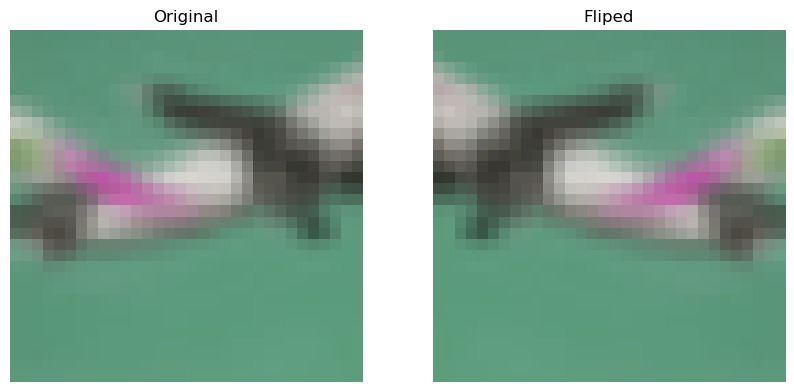

In [70]:
# PairedFlipDataset

fst_50 = fix_scale_transform(50)

fst_50_test_dataset = datasets.CIFAR10(
  root="data",
  download=True,
  train=False,
  transform=fst_50
)

fst_50_paired_flip_test_dataset = PairedFlipDataset(fst_50_test_dataset)

img, img_flipped, label = fst_50_paired_flip_test_dataset[np.random.choice(len(fst_50_paired_flip_test_dataset))]

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(denormalize(img).permute(1, 2, 0))
plt.axis(False)

plt.subplot(1, 2, 2)
plt.title("Fliped")
plt.imshow(denormalize(img_flipped).permute(1, 2, 0))
plt.axis(False)

plt.show()

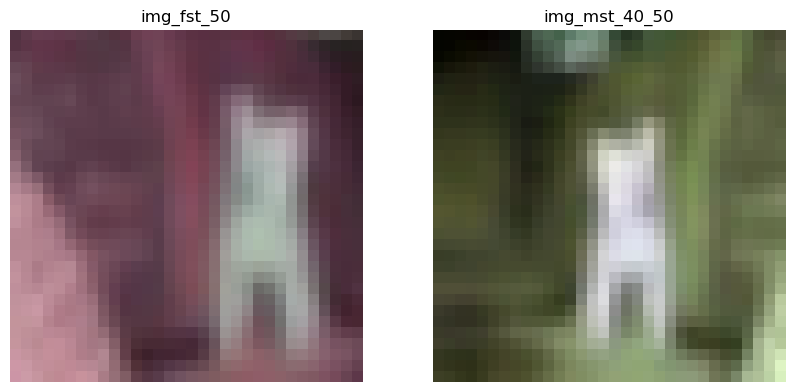

In [71]:
# MultiTransformDataset

fst_50 = fix_scale_transform(50)
mst_40_50 = multi_scale_transform(40, 50)

multi_trans_test_dataset = MultiTransformDataset(default_test_dataset, fst_50, mst_40_50)

img_fst_50, img_mst_40_50, label = multi_trans_test_dataset[np.random.choice(len(fst_50_paired_flip_test_dataset))]

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title("img_fst_50")
plt.imshow(denormalize(img_fst_50).permute(1, 2, 0))
plt.axis(False)

plt.subplot(1, 2, 2)
plt.title("img_mst_40_50")
plt.imshow(denormalize(img_mst_40_50).permute(1, 2, 0))
plt.axis(False)

plt.show()

# 3. Training and Evaluation Functions

In [60]:
def to_device(*args, device=device):
  return [arg.to(device, non_blocking=True) for arg in args]

def train_epoch(dataloader, model, criterion, optimizer, accuracy):
  model.train()

  train_loss, train_acc = 0, 0

  for X, y in tqdm(dataloader, desc="Training", leave=False):
    X, y = to_device(X, y)

    logits = model(X)

    loss = criterion(logits, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    with torch.no_grad():
      probs = torch.softmax(logits, dim=1)
      preds = probs.argmax(dim=1)

      train_loss += loss.cpu().item()
      train_acc += accuracy(preds, y).cpu().item()

  train_loss /= len(dataloader)
  train_acc /= len(dataloader)

  return train_loss, train_acc

def validate_epoch(dataloader, model, criterion, accuracy):
  model.eval()

  val_loss, val_acc = 0, 0

  with torch.no_grad():
    for X, y in tqdm(dataloader, desc="Validate", leave=False):
      X, y = to_device(X, y)

      logits = model(X)
      probs = torch.softmax(logits, dim=1)
      preds = probs.argmax(dim=1)

      loss = criterion(logits, y)

      val_loss += loss.cpu().item()
      val_acc += accuracy(preds, y).cpu().item()

  val_loss /= len(dataloader)
  val_acc /= len(dataloader)

  return val_loss, val_acc

In [61]:
def train(n_epochs,
          train_dataloader,
          test_dataloader,
          model,
          criterion,
          optimizer,
          scheduler,
          accuracy):

  train_losses, train_accs = [], []
  val_losses, val_accs = [], []

  for epoch in tqdm(range(1, n_epochs + 1), desc="Epoch", leave=False):
    train_loss, train_acc = train_epoch(train_dataloader, model, criterion, optimizer, accuracy)
    val_loss, val_acc = validate_epoch(test_dataloader, model, criterion, accuracy)

    if scheduler is not None:
      scheduler.step(val_acc)

    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)

    print(f"Epoch: {epoch: 4d} | Train loss: {train_loss: .5f} | Train acc: {train_acc: .5f} | Val loss: {val_loss: .5f} | Val acc: {val_acc: .5f}")

  return train_losses, train_accs, val_losses, val_accs

In [62]:
def plot_train_log(n_epochs, train_losses, train_accs, val_losses, val_accs):
  epochs = np.arange(1, n_epochs + 1)

  plt.figure(figsize=(15, 5))

  plt.subplot(1, 2, 1)
  plt.plot(epochs, train_losses, label="train loss")
  plt.plot(epochs, val_losses, label="val loss")
  plt.title("Loss")
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(epochs, train_accs, label="train acc")
  plt.plot(epochs, val_accs, label="val acc")
  plt.title("Acc")
  plt.legend()

In [72]:
class VGGBlock(nn.Module):
  def __init__(self, in_channels, out_channels, n_convs, kernel_sizes=3):
    super().__init__()
    
    assert isinstance(kernel_sizes, int) or len(kernel_sizes) == n_convs
    
    if isinstance(kernel_sizes, int):
      kernel_sizes = [kernel_sizes for _ in range(n_convs)]
        
    paddings = [(kernel_size - 1) // 2 for kernel_size in kernel_sizes]
    
    layers = []

    for kernel_size, padding in zip(kernel_sizes, paddings):
      assert 2 * padding - kernel_size + 1 == 0

      layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, padding=padding))
      layers.append(nn.BatchNorm2d(out_channels))
      layers.append(nn.ReLU(inplace=True))

      in_channels = out_channels

    layers.append(nn.MaxPool2d(kernel_size=2))

    self.block = nn.Sequential(*layers)

  def forward(self, x):
    return self.block(x)

class TinyVGG_A(nn.Module):
  def __init__(self):
    super().__init__()

    self.features = nn.Sequential(
      VGGBlock(3, 8, n_convs=1),
      VGGBlock(8, 16, n_convs=1),
      VGGBlock(16, 32, n_convs=2),
      VGGBlock(32, 64, n_convs=2),
      VGGBlock(64, 64, n_convs=2),
    )

    self.classifier = nn.Sequential(
      nn.Flatten(),
      nn.Linear(64, 64),
      nn.ReLU(inplace=True),
      nn.Dropout(p=0.5),
      nn.Linear(64, 64),
      nn.ReLU(inplace=True),
      nn.Dropout(p=0.5),
      nn.Linear(64, 10),
    )

  def forward(self, x):
    out = self.features(x)
    out = self.classifier(out)
    return out

Files already downloaded and verified
Files already downloaded and verified


Epoch:    1 | Train loss:  1.90636 | Train acc:  0.27171 | Val loss:  1.60243 | Val acc:  0.39157


Epoch:    2 | Train loss:  1.67777 | Train acc:  0.37448 | Val loss:  1.50009 | Val acc:  0.44409


Epoch:    3 | Train loss:  1.54569 | Train acc:  0.45216 | Val loss:  1.36545 | Val acc:  0.52766


Epoch:    4 | Train loss:  1.44636 | Train acc:  0.50382 | Val loss:  1.43027 | Val acc:  0.50739


Epoch:    5 | Train loss:  1.37746 | Train acc:  0.53353 | Val loss:  1.19647 | Val acc:  0.58636


Epoch:    6 | Train loss:  1.32244 | Train acc:  0.55778 | Val loss:  1.20226 | Val acc:  0.58446


Epoch:    7 | Train loss:  1.27614 | Train acc:  0.57600 | Val loss:  1.17894 | Val acc:  0.59085


Epoch:    8 | Train loss:  1.24338 | Train acc:  0.59047 | Val loss:  1.06776 | Val acc:  0.63399


Epoch:    9 | Train loss:  1.21910 | Train acc:  0.59999 | Val loss:  1.09454 | Val acc:  0.63299


Epoch:   10 | Train loss:  1.18815 | Train acc:  0.61226 | Val loss:  1.03119 | Val acc:  0.65086


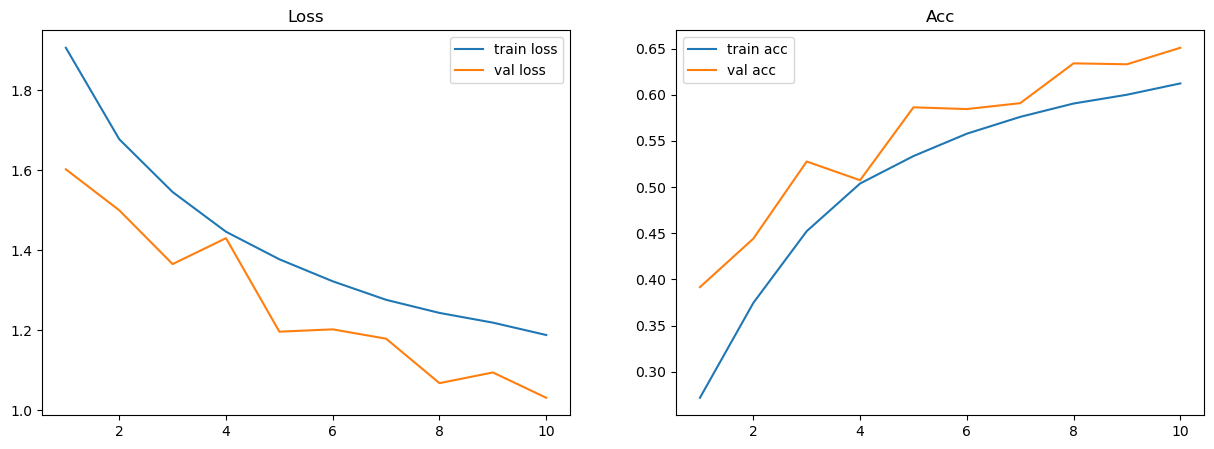

In [73]:
# Dataset and Transform

fst40 = fix_scale_transform(s=40)

train_dataset = datasets.CIFAR10(
  root="data",
  download=True,
  train=True,
  transform=fst40
)

test_dataset = datasets.CIFAR10(
  root="data",
  download=True,
  train=False,
  transform=fst40
)

# Dataloader

batch_size = 32

train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=batch_size,
                              shuffle=True,
                              pin_memory=True)

test_dataloader = DataLoader(dataset=test_dataset,
                             batch_size=batch_size,
                             shuffle=False,
                             pin_memory=True)

# Model and optimization

model = TinyVGG_A().to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params=model.parameters(),
                            momentum=0.9,
                            lr=0.01)

# Metric

accuracy = Accuracy(task="multiclass", num_classes=len(train_dataset.classes)).to(device)

# Train loop

n_epochs = 10
logs = train(n_epochs=n_epochs,
             train_dataloader=train_dataloader,
             test_dataloader=test_dataloader,
             model=model,
             criterion=criterion,
             optimizer=optimizer,
             scheduler=None,
             accuracy=accuracy)

plot_train_log(n_epochs, *logs)

In [74]:
batch_size = 32

test_dataloader = DataLoader(dataset=test_dataset,
                             batch_size=batch_size,
                             shuffle=False,
                             pin_memory=True)

criterion = nn.CrossEntropyLoss()

accuracy = Accuracy(task="multiclass", num_classes=len(train_dataset.classes)).to(device)

_, val_acc = validate_epoch(test_dataloader, model, criterion, accuracy)

val_acc

0.6523562300319489

In [39]:
class TinyVGG_B(nn.Module):
  def __init__(self):
    super().__init__()

    self.features = nn.Sequential(
      VGGBlock(3, 8, n_convs=2),
      VGGBlock(8, 16, n_convs=2),
      VGGBlock(16, 32, n_convs=2),
      VGGBlock(32, 64, n_convs=2),
      VGGBlock(64, 64, n_convs=2),
    )

    self.classifier = nn.Sequential(
      nn.Flatten(),
      nn.Linear(64, 64),
      nn.ReLU(inplace=True),
      nn.Dropout(p=0.5),
      nn.Linear(64, 64),
      nn.ReLU(inplace=True),
      nn.Dropout(p=0.5),
      nn.Linear(64, 10),
    )

  def forward(self, x):
    out = self.features(x)
    out = self.classifier(out)
    return out

Files already downloaded and verified
Files already downloaded and verified


Epoch:    1 | Train loss:  1.89371 | Train acc:  0.27127 | Val loss:  1.58323 | Val acc:  0.38978


Epoch:    2 | Train loss:  1.65605 | Train acc:  0.37844 | Val loss:  1.51702 | Val acc:  0.41873


Epoch:    3 | Train loss:  1.54754 | Train acc:  0.43974 | Val loss:  1.37463 | Val acc:  0.52656


Epoch:    4 | Train loss:  1.44767 | Train acc:  0.50366 | Val loss:  1.28093 | Val acc:  0.55321


Epoch:    5 | Train loss:  1.36063 | Train acc:  0.54035 | Val loss:  1.14557 | Val acc:  0.60713


Epoch:    6 | Train loss:  1.29147 | Train acc:  0.56874 | Val loss:  1.13046 | Val acc:  0.60992


Epoch:    7 | Train loss:  1.24168 | Train acc:  0.58737 | Val loss:  1.06934 | Val acc:  0.63458


Epoch:    8 | Train loss:  1.19352 | Train acc:  0.60191 | Val loss:  1.04332 | Val acc:  0.64766


Epoch:    9 | Train loss:  1.16006 | Train acc:  0.61968 | Val loss:  1.02212 | Val acc:  0.64377


Epoch:   10 | Train loss:  1.12821 | Train acc:  0.62996 | Val loss:  0.99663 | Val acc:  0.66514


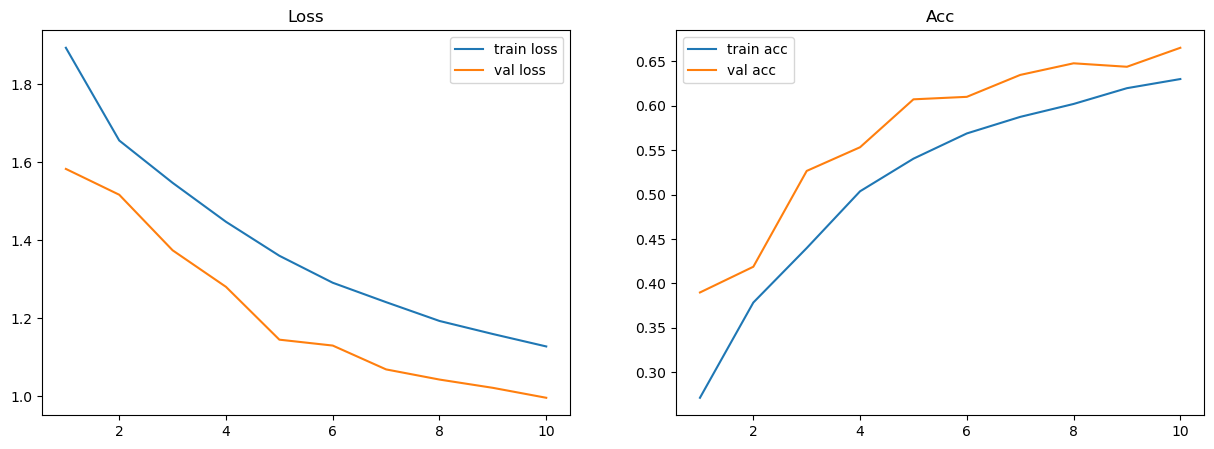

In [38]:
# Dataset and Transform

fst40 = fix_scale_transform(s=40)

train_dataset = datasets.CIFAR10(
  root="data",
  download=True,
  train=True,
  transform=fst40
)

test_dataset = datasets.CIFAR10(
  root="data",
  download=True,
  train=False,
  transform=fst40
)

# Dataloader

batch_size = 32

train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=batch_size,
                              shuffle=True,
                              pin_memory=True)

test_dataloader = DataLoader(dataset=test_dataset,
                             batch_size=batch_size,
                             shuffle=False,
                             pin_memory=True)

# Model and optimization

model = TinyVGG_B().to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params=model.parameters(),
                            momentum=0.9,
                            lr=0.01)

# Metric

accuracy = Accuracy(task="multiclass", num_classes=len(train_dataset.classes)).to(device)

# Train loop

n_epochs = 10
logs = train(n_epochs=n_epochs,
             train_dataloader=train_dataloader,
             test_dataloader=test_dataloader,
             model=model,
             criterion=criterion,
             optimizer=optimizer,
             scheduler=None,
             accuracy=accuracy)

plot_train_log(n_epochs, *logs)

In [43]:
batch_size = 32

test_dataloader = DataLoader(dataset=test_dataset,
                             batch_size=batch_size,
                             shuffle=False,
                             pin_memory=True)

criterion = nn.CrossEntropyLoss()

accuracy = Accuracy(task="multiclass", num_classes=len(train_dataset.classes)).to(device)

_, val_acc = validate_epoch(test_dataloader, model, criterion, accuracy)

val_acc

0.6579472843450479

In [44]:
class TinyVGG_C(nn.Module):
  def __init__(self):
    super().__init__()

    self.features = nn.Sequential(
      VGGBlock(3, 8, n_convs=2),
      VGGBlock(8, 16, n_convs=2),
      VGGBlock(16, 32, n_convs=3, kernel_sizes=(3, 3, 1)),
      VGGBlock(32, 64, n_convs=3, kernel_sizes=(3, 3, 1)),
      VGGBlock(64, 64, n_convs=3, kernel_sizes=(3, 3, 1)),
    )

    self.classifier = nn.Sequential(
      nn.Flatten(),
      nn.Linear(64, 64),
      nn.ReLU(inplace=True),
      nn.Dropout(p=0.5),
      nn.Linear(64, 64),
      nn.ReLU(inplace=True),
      nn.Dropout(p=0.5),
      nn.Linear(64, 10),
    )

  def forward(self, x):
    out = self.features(x)
    out = self.classifier(out)
    return out

Files already downloaded and verified
Files already downloaded and verified


Epoch:    1 | Train loss:  1.93338 | Train acc:  0.25450 | Val loss:  1.64768 | Val acc:  0.36891


Epoch:    2 | Train loss:  1.68718 | Train acc:  0.36276 | Val loss:  1.68784 | Val acc:  0.35383


Epoch:    3 | Train loss:  1.58191 | Train acc:  0.42177 | Val loss:  1.40181 | Val acc:  0.48083


Epoch:    4 | Train loss:  1.47852 | Train acc:  0.47533 | Val loss:  1.35528 | Val acc:  0.52117


Epoch:    5 | Train loss:  1.39744 | Train acc:  0.51753 | Val loss:  1.23576 | Val acc:  0.56300


Epoch:    6 | Train loss:  1.33098 | Train acc:  0.54545 | Val loss:  1.15309 | Val acc:  0.60094


Epoch:    7 | Train loss:  1.27200 | Train acc:  0.57434 | Val loss:  1.15796 | Val acc:  0.60294


Epoch:    8 | Train loss:  1.23642 | Train acc:  0.59027 | Val loss:  1.09195 | Val acc:  0.62600


Epoch:    9 | Train loss:  1.18848 | Train acc:  0.60815 | Val loss:  1.07114 | Val acc:  0.63289


Epoch:   10 | Train loss:  1.16396 | Train acc:  0.61396 | Val loss:  1.07555 | Val acc:  0.63179


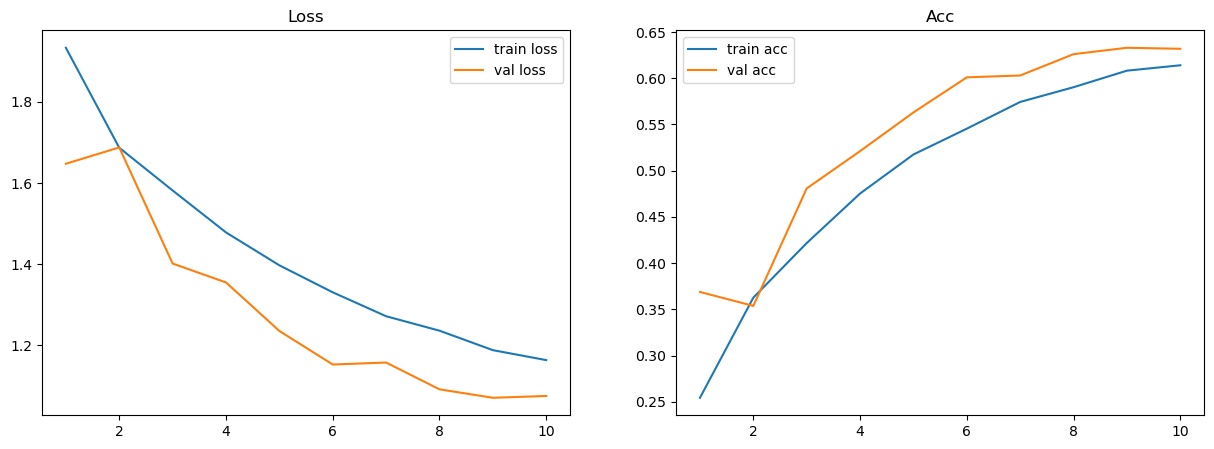

In [49]:
# Dataset and Transform

fst40 = fix_scale_transform(s=40)

train_dataset = datasets.CIFAR10(
  root="data",
  download=True,
  train=True,
  transform=fst40
)

test_dataset = datasets.CIFAR10(
  root="data",
  download=True,
  train=False,
  transform=fst40
)

# Dataloader

batch_size = 32

train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=batch_size,
                              shuffle=True,
                              pin_memory=True)

test_dataloader = DataLoader(dataset=test_dataset,
                             batch_size=batch_size,
                             shuffle=False,
                             pin_memory=True)

# Model and optimization

model = TinyVGG_C().to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params=model.parameters(),
                            momentum=0.9,
                            lr=0.01)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", factor=0.1, patience=3)

# Metric

accuracy = Accuracy(task="multiclass", num_classes=len(train_dataset.classes)).to(device)

# Train loop

n_epochs = 10
logs = train(n_epochs=n_epochs,
             train_dataloader=train_dataloader,
             test_dataloader=test_dataloader,
             model=model,
             criterion=criterion,
             optimizer=optimizer,
             scheduler=scheduler,
             accuracy=accuracy)

plot_train_log(n_epochs, *logs)

In [50]:
batch_size = 32

test_dataloader = DataLoader(dataset=test_dataset,
                             batch_size=batch_size,
                             shuffle=False,
                             pin_memory=True)

criterion = nn.CrossEntropyLoss()

accuracy = Accuracy(task="multiclass", num_classes=len(train_dataset.classes)).to(device)

_, val_acc = validate_epoch(test_dataloader, model, criterion, accuracy)

val_acc

0.6373801916932907

In [75]:
torch.save(model.state_dict(), "TinyVGG_A_test_chk.pth")